In [1]:
import pandas as pd
import numpy as np
import datetime
import math

In [53]:
inp = pd.read_parquet('/Users/angad/Downloads/BTC-USDT.parquet',engine = 'pyarrow')
inp.reset_index(level=0,inplace=True)
inp.shape

(1828151, 10)

In [54]:
#Keep the important columns only
df = inp[['open_time','open','high','low','close','volume']]


In [55]:
#Start from 0:0:0 on 18th Aug 2017, rmeove partial data of 17th Aug 2017
df = df[df['open_time']>=datetime.datetime(2017,8,18,0,0)]
df.reset_index(inplace =True,drop=True)
df.shape


AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
df.head(30)

In [56]:
#Prepare data for different timeframe candles

def convert_min_hr_day(str):
    last_char = str[-1]
    rem_char = int(str[:-1])
    
    if last_char =='m':
        time_unit = 1*rem_char
    elif last_char == 'h':
        time_unit = 60*rem_char
    elif last_char == 'd':
        time_unit = 24*60*rem_char
    else:
        time_unit=0
    print("time_unit:",time_unit)
    return time_unit

In [66]:
def prepare_data(df,time):
    row_count = df.shape[0]
    time_unit = convert_min_hr_day(time)
    no_of_levels = math.ceil(row_count/time_unit)
    levels_list = list(range(1,no_of_levels+1))
    levels_list_expand = sorted(levels_list*time_unit)
    group_final_list = levels_list_expand[:row_count]
    
    df2 = df.copy()
    df2.insert(0,'group',group_final_list)
    
    output = pd.DataFrame()
    
    output['open'] = df2.groupby(['group']).first().open
    output['high'] = df2.groupby(['group'])['high'].max()
    output['low'] = df2.groupby(['group'])['low'].min()
    output['close'] = df2.groupby(['group']).last().close
    output['volume'] = df2.groupby(['group'])['volume'].sum()
    output['date'] = df2.groupby(['group']).first().open_time
    output['date'] = pd.to_datetime(output['date'])
    #output['date'] = output['date'].dt.date
    output.index= output['date']
    
    
    
    print('output_shape:',output.shape)
    return output
    
    

In [113]:
output = prepare_data(df,'20d')

time_unit: 28800
output_shape: (64, 6)


In [114]:
output.head(10)

,open,high,low,close,volume,date
date,,,,,,
2017-08-17 04:00:00.000,4261.479980,4939.189941,3400.000000,4430.020020,15007.674805,2017-08-17 04:00:00.000
2017-09-06 04:00:00.000,4430.020020,4788.589844,2817.000000,3937.000000,18632.933594,2017-09-06 04:00:00.000
2017-09-26 11:01:00.000,3931.000000,5922.299805,3872.810059,5705.149902,17884.791016,2017-09-26 11:01:00.000
2017-10-16 11:01:00.000,5705.140137,7480.990234,5037.950195,7415.109863,35634.753906,2017-10-16 11:01:00.000
2017-11-05 11:01:00.000,7416.029785,8448.990234,5325.009766,8391.320312,61777.738281,2017-11-05 11:01:00.000
2017-11-25 11:01:00.000,8391.330078,17982.220703,8288.000000,17806.519531,177701.796875,2017-11-25 11:01:00.000
2017-12-15 11:01:20.799,17788.609375,19798.679688,10961.000000,14472.419922,326496.406250,2017-12-15 11:01:20.799
2018-01-04 14:26:00.000,14448.070312,17176.240234,9035.000000,11417.000000,602568.000000,2018-01-04 14:26:00.000
2018-01-24 14:26:00.000,11416.000000,12244.000000,6000.009766,9313.700195,761788.562500,2018-01-24 14:26:00.000


import plotly.graph_objects as go

from datetime import datetime


fig = go.Figure(data=[go.Candlestick(x=output.index,
                open=output['open'],
                high=output['high'],
                low=output['low'],
                close=output['volume'])])

fig.show()

In [80]:
import mplfinance as fplt


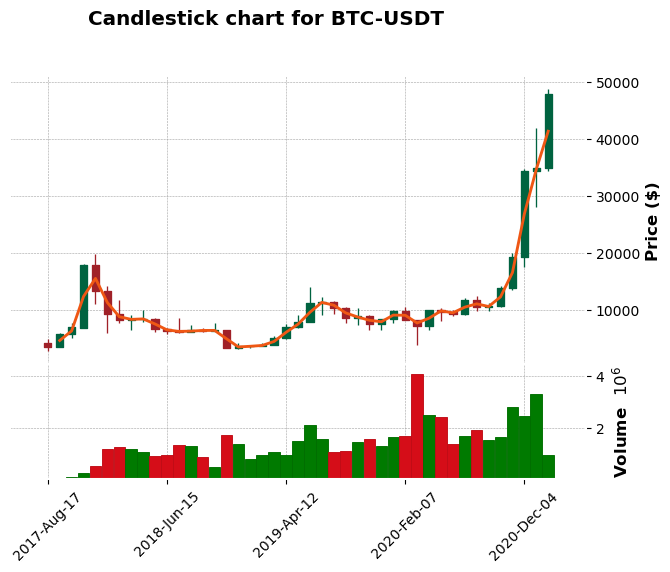

In [83]:
fplt.plot(
            output,
            type='candle',
            style='charles',

            title='Candlestick chart for BTC-USDT',
            ylabel='Price ($)',
            volume=True,
            mav = 2,
            #savefig = 'plot.png'
        )

In [84]:
import plotly.graph_objects as go

candlestick = go.Candlestick(
                            x=output.index,
                            open=output['open'],
                            high=output['high'],
                            low=output['low'],
                            close=output['close']
                            )

fig = go.Figure(data=[candlestick])

fig.show()


In [87]:
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)


In [88]:
output.iplot(kind="candle",
                          keys=["open", "high", "low", "close"],
                          rangeslider=True
                          )

In [116]:
#apple_df = pd.read_csv('/datasets/AAPL.csv', index_col=0, parse_dates=True)

qf=cf.QuantFig(output,title='BTC-USDT data',legend='top',name='plot')

qf.add_bollinger_bands()
qf.add_volume()
#qf.add_resistance(date = '2018-03-17')
qf.add_support(date = '2018-03-17')
#qf.add_trendline(date0 = '2017-11-15',date1 ='2020-12-04',text ='Trend')
#qf.add_volume()

qf.iplot()

In [91]:
output

,open,high,low,close,volume,date
date,,,,,,
2017-08-17 04:00:00.000,4261.479980,4939.189941,2817.000000,3529.989990,2.543288e+04,2017-08-17 04:00:00.000
2017-09-16 11:01:00.000,3529.989990,5922.299805,3499.020020,5705.149902,2.609252e+04,2017-09-16 11:01:00.000
2017-10-16 11:01:00.000,5705.140137,7770.020020,5037.950195,6898.879883,6.000060e+04,2017-10-16 11:01:00.000
2017-11-15 11:01:00.000,6888.060059,17982.220703,6888.060059,17806.519531,2.151137e+05,2017-11-15 11:01:00.000
2017-12-15 11:01:20.799,17788.609375,19798.679688,10961.000000,13220.000000,5.211288e+05,2017-12-15 11:01:20.799
2018-01-14 14:26:00.000,13220.000000,14249.990234,6000.009766,9313.700195,1.169724e+06,2018-01-14 14:26:00.000
2018-02-15 00:48:00.000,9319.919922,11786.009766,7650.000000,8261.009766,1.233179e+06,2018-02-15 00:48:00.000
2018-03-17 00:48:00.000,8261.040039,9177.009766,6430.000000,8384.000000,1.178935e+06,2018-03-17 00:48:00.000
2018-04-16 00:48:00.000,8383.910156,10020.000000,7825.399902,8427.370117,1.050933e+06,2018-04-16 00:48:00.000
